In [74]:
import numpy as np 
import pandas as pd 
import time
pd.set_option('display.max_columns', None) 



# PREPROCESAMIENTO
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score


# PIPELINES
from sklearn.datasets import fetch_openml
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import SelectKBest, chi2
from sklearn import set_config
# configuración para mostrar los pipelines de modo grafico
set_config(display=None)


# MODELOS
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier





# VISUALIACIÓN
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [ ]:

# Esto es para acceder al directorio de arcgivos de Kaggle
# No hace falta correrlo si se tienen los datos en forma local
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/this-week-in-chess-archive/twic_master.csv
/kaggle/input/this-week-in-chess-archive/twic_master.parquet
/kaggle/input/this-week-in-chess-archive/metadata.csv
/kaggle/input/this-week-in-chess-archive/pgns/twic1032.pgn
/kaggle/input/this-week-in-chess-archive/pgns/twic1351.pgn
/kaggle/input/this-week-in-chess-archive/pgns/twic1167.pgn
/kaggle/input/this-week-in-chess-archive/pgns/twic1452.pgn
/kaggle/input/this-week-in-chess-archive/pgns/twic963.pgn
/kaggle/input/this-week-in-chess-archive/pgns/twic1027.pgn
/kaggle/input/this-week-in-chess-archive/pgns/twic1179.pgn
/kaggle/input/this-week-in-chess-archive/pgns/twic1133.pgn
/kaggle/input/this-week-in-chess-archive/pgns/twic1176.pgn
/kaggle/input/this-week-in-chess-archive/pgns/twic1442.pgn
/kaggle/input/this-week-in-chess-archive/pgns/twic1279.pgn
/kaggle/input/this-week-in-chess-archive/pgns/twic1342.pgn
/kaggle/input/this-week-in-chess-archive/pgns/twic1069.pgn
/kaggle/input/this-week-in-chess-archive/pgns/twic1195.pgn
/ka

In [ ]:
# llamo al archivo "twic_master.csv" y creo el dataframe
df = pd.read_csv('/kaggle/input/this-week-in-chess-archive/twic_master.csv')


# esto es para que muestre todas las columnas del df
pd.set_option('display.max_columns', None) 

In [ ]:
# ACÁ ENTRAN LOS DATOS

# ACÁ TENEMOS LOS DATOS CRUDOS

In [ ]:
# Casi 2 millones de partidas
df.shape

(1971319, 29)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1971319 entries, 0 to 1971318
Data columns (total 29 columns):
 #   Column          Dtype  
---  ------          -----  
 0   twic_number     int64  
 1   White           object 
 2   Black           object 
 3   Date            object 
 4   EventDate       object 
 5   Event           object 
 6   Result          object 
 7   mainline_moves  object 
 8   Site            object 
 9   Online          bool   
 10  Round           object 
 11  ECO             object 
 12  Opening         object 
 13  WhiteFideId     object 
 14  BlackFideId     object 
 15  WhiteElo        float64
 16  BlackElo        float64
 17  Variation       object 
 18  WhiteTitle      object 
 19  BlackTitle      object 
 20  WhiteTeam       object 
 21  BlackTeam       object 
 22  EventType       object 
 23  FEN             object 
 24  SetUp           float64
 25  Variant         object 
 26  Board           float64
 27  PlyCount        float64
 28  EventCategor

Las columnas SetUp, FEN y Variant cuando no son nulas hacen referencia a la modalidad chess960. Voy a dropear los registros de esta modalidad, son alrededor de 550 partidas.

Las columnas PlyCount, Board, EventCategory, BlackTeam y WhiteTeam no me aportan nada interesante. Las primeras tres son casi todas nulas, y los equipos no interesan.

In [ ]:
# Primero me quedo solo con los registros nulos en las columnas relacionadas con la modalidad 960
# De este modo me voy a quedar con las partidas que NO son 960chess
df = df[ (df.Variant.isna()) & (df.FEN.isna()) & (df.SetUp.isna()) ]

# Despues tiro estas columnas que ya no me dicen nada
df = df.drop(["Variant", "FEN", "SetUp"], axis=1)

In [ ]:
# Tiro las columnas que no interesan
df = df.drop(["twic_number", "White", "Black", "Date", "EventDate", "Site", "Online", "Round", "ECO", "Variation", "WhiteTitle", "BlackTitle", "PlyCount", "Board", "EventCategory", "BlackTeam", "WhiteTeam"], axis=1)

In [ ]:
display(df.shape)
df.columns

(1970769, 9)

Index(['Event', 'Result', 'mainline_moves', 'Opening', 'WhiteFideId',
       'BlackFideId', 'WhiteElo', 'BlackElo', 'EventType'],
      dtype='object')

In [ ]:
# Vamos a poner todas las letras en minuscula y eliminar espacios en los extremos
# En "mainline_moves" y "ECO" NO toco las mayúsculas ya tienen relevancia en la notación.
cols = ["Event", "Opening", "EventType"]
for feature in cols:
    
    df[feature] = df[feature].str.lower().str.strip()


In [ ]:
# filtramos los registros con resultados mal cargados
display(df.shape)
df = df[(df.Result=="1-0") | (df.Result=="0-1") | (df.Result=="1/2-1/2")]
display(df.shape)

(1970769, 9)

(1970717, 9)

In [ ]:
df.isna().sum()

Event                   0
Result                  0
mainline_moves      10882
Opening             15422
WhiteFideId         25639
BlackFideId         25929
WhiteElo            69592
BlackElo            70964
EventType         1778460
dtype: int64

In [ ]:
# No puedo dejar registros con nulos de Elo

indexo = df[ (df.WhiteElo.isna()) | (df.BlackElo.isna()) | (df.WhiteFideId.isna()) | (df.BlackFideId.isna())].index
  
df.drop(indexo, inplace = True)
  
df.isna().sum()

Event                   0
Result                  0
mainline_moves       8516
Opening             12699
WhiteFideId             0
BlackFideId             0
WhiteElo                0
BlackElo                0
EventType         1674694
dtype: int64

In [ ]:
# Pasemos los números de identificación fide que son tipo object a enteros:

df['WhiteFideId'] = pd.to_numeric(df['WhiteFideId']).convert_dtypes() 

df['BlackFideId'] = pd.to_numeric(df['BlackFideId']).convert_dtypes() 

# Así elimino comas que hacen que el mismo id se lea distinto

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1850859 entries, 0 to 1971318
Data columns (total 9 columns):
 #   Column          Dtype  
---  ------          -----  
 0   Event           object 
 1   Result          object 
 2   mainline_moves  object 
 3   Opening         object 
 4   WhiteFideId     Int64  
 5   BlackFideId     Int64  
 6   WhiteElo        float64
 7   BlackElo        float64
 8   EventType       object 
dtypes: Int64(2), float64(2), object(5)
memory usage: 144.7+ MB


In [ ]:
# Ahora vuelvo los IDs a str, ya que luego les haré ohe
df.WhiteFideId = df.WhiteFideId.astype(str)
df.BlackFideId = df.BlackFideId.astype(str)

# Y los Elos los paso a enteros
df.WhiteElo = df.WhiteElo.astype(int)
df.BlackElo = df.BlackElo.astype(int)


df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1850859 entries, 0 to 1971318
Data columns (total 9 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   Event           object
 1   Result          object
 2   mainline_moves  object
 3   Opening         object
 4   WhiteFideId     object
 5   BlackFideId     object
 6   WhiteElo        int64 
 7   BlackElo        int64 
 8   EventType       object
dtypes: int64(2), object(7)
memory usage: 141.2+ MB


In [ ]:
# redefinamos los valores del target:

def xgb_target(valor):
    if valor=="1-0":
        return 0
    if valor=="0-1":
        return 1
    if valor=="1/2-1/2":
        return 2
    
df["Result"] = df.Result.apply(lambda x: xgb_target(x))

In [ ]:
# En la columna "mainline_moves" vamos a dejar sólo el número de movimientos:
df["mainline_moves"] = df.mainline_moves.apply(lambda x: len(x.split())//3 if type(x)==str else x)


In [ ]:
# Hagamos un df con partidas blitz
df_bz = df[(df.Event.str.contains("blitz")) | (df.EventType.str.contains("blitz"))]
df_bz.shape

(91377, 9)

In [ ]:
df_bz.isna().sum()

Event                 0
Result                0
mainline_moves      495
Opening             805
WhiteFideId           0
BlackFideId           0
WhiteElo              0
BlackElo              0
EventType         70843
dtype: int64

In [ ]:
# Hagamos un df con partidas rápidas
df_rd = df[(df.Event.str.contains("rapid")) | (df.EventType.str.contains("rapid"))]
df_rd.shape

(68587, 9)

In [ ]:
df_rd.isna().sum()

Event                 0
Result                0
mainline_moves      546
Opening             929
WhiteFideId           0
BlackFideId           0
WhiteElo              0
BlackElo              0
EventType         60241
dtype: int64

In [ ]:
# Dropiemos "Event" y "eventtype" que ya nos separaron los controles de tiempo:
df_bz = df_bz.drop(["Event", "EventType"], axis=1)
df_rd = df_rd.drop(["Event", "EventType"], axis=1)

In [ ]:
# Sólo quedan algunos nans en las columnas de movidas y aperturas
display(df_bz.isna().sum())
display(df_rd.isna().sum())

Result              0
mainline_moves    495
Opening           805
WhiteFideId         0
BlackFideId         0
WhiteElo            0
BlackElo            0
dtype: int64

Result              0
mainline_moves    546
Opening           929
WhiteFideId         0
BlackFideId         0
WhiteElo            0
BlackElo            0
dtype: int64

Ahora con los dataframes separados en blitz y rapid, podemos empezar a ver si los resultados son separables a simple vista. Vamos con un pairplot.

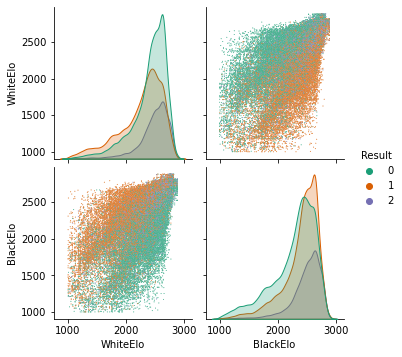

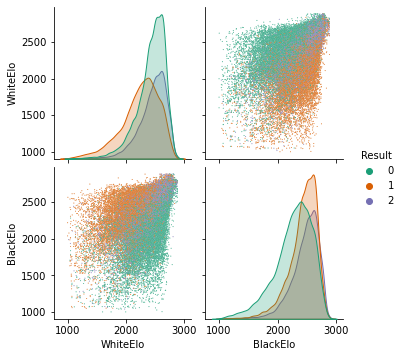

In [ ]:
sns.pairplot(df_bz, vars=['WhiteElo', 'BlackElo'], hue = "Result", plot_kws={"s": 1}, palette="Dark2")#, markers=["o", "s"])
sns.pairplot(df_rd, vars=['WhiteElo', 'BlackElo'], hue = "Result", plot_kws={"s": 1}, palette="Dark2")#, markers=["o", "s"])


# DATASETS LIMPIOS Y SEPARADOS POR CONTROL DE TIEMPO
AHORA ENTRAN LOS PIPELINES

In [8]:
# EN COLAB ARRANCO ACÁ:
#df_bz = pd.read_csv('/content/blitz_pipe.csv')
#df_rd = pd.read_csv('/content/rapid_pipe.csv')

In [30]:
# Separemos features y target
y_bz = df_bz.Result
X_bz = df_bz.drop(["Result"],axis=1)

X_bz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91377 entries, 0 to 91376
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   mainline_moves  90882 non-null  float64
 1   Opening         90572 non-null  object 
 2   WhiteFideId     91377 non-null  int64  
 3   BlackFideId     91377 non-null  int64  
 4   WhiteElo        91377 non-null  int64  
 5   BlackElo        91377 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 4.2+ MB


In [75]:
# Hagamos un transformer para imputar
t1 = ColumnTransformer(
[('imputa_movidas', SimpleImputer(strategy='mean'), [0]),
('imputa_apertura', SimpleImputer(strategy='most_frequent'), [1])],
remainder='passthrough')

In [76]:
# Hagamos un transformer para hacer dummies de categóricas
t2 = ColumnTransformer(
[('ohe_ids', OneHotEncoder(min_frequency=200, handle_unknown='infrequent_if_exist', sparse=False), [2,3]),
('ohe_apertura', OneHotEncoder(min_frequency=2000, handle_unknown='infrequent_if_exist', sparse=False), [1])],
remainder = 'passthrough')


In [77]:
# Hagamos un transformer que escalee las columnas numéricas
t3 = ColumnTransformer([('escaleo', MinMaxScaler(), [0, 4, 5])], remainder = 'passthrough')


In [78]:
# Vamos con un arbol como modelo
arbol = DecisionTreeClassifier(max_depth=10) #para que no overfitee tanto

In [82]:
# Ahora creamos el pipeline con los transformers y el modelo:
# Es importante el nombre del último paso "clf"
pasos = [('tr1', t1), ('tr2', t2), ('tr3', t3), ('clf', arbol)]
pipe = Pipeline(pasos)

In [83]:
# En detalle, con los nombres de cada paso:
pipe.named_steps

{'tr1': ColumnTransformer(remainder='passthrough',
                   transformers=[('imputa_movidas', SimpleImputer(), [0]),
                                 ('imputa_apertura',
                                  SimpleImputer(strategy='most_frequent'),
                                  [1])]),
 'tr2': ColumnTransformer(remainder='passthrough',
                   transformers=[('ohe_ids',
                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                min_frequency=200,
                                                sparse=False),
                                  [2, 3]),
                                 ('ohe_apertura',
                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                min_frequency=2000,
                                                sparse=False),
                                  [1])]),
 'tr3': ColumnTransformer(remainder='pas

In [71]:
# Hagamos un split en blitz:
X_train_bz, X_test_bz, y_train_bz, y_test_bz = train_test_split(X_bz, y_bz, test_size=0.2, random_state=0, stratify=y_bz)

In [84]:
# Entrenemos
pipe.fit(X_train_bz, y_train_bz)


Pipeline(steps=[('tr1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('imputa_movidas',
                                                  SimpleImputer(), [0]),
                                                 ('imputa_apertura',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  [1])])),
                ('tr2',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe_ids',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                min_frequency=200,
                                                                sparse=False),
                                                  [2, 3]),
                                                 ('ohe_apertura',
                      

In [73]:
# testeo
y_pred_bz = pipe.predict(X_test_bz)

accuracy_score(y_test_bz, y_pred_bz)

0.5854125629240534

In [137]:
# Y SI QUIERO COMPARAR CLASIFICADORES Y AL MISMO TIEMPO TUNEARLOS:

log_reg = LogisticRegression()
nb = BernoulliNB()
knn = KNeighborsClassifier()
svm = SVC()
mlp = MLPClassifier(max_iter=500)
dt = DecisionTreeClassifier()
et = ExtraTreesClassifier()
rf = RandomForestClassifier()
xgb = XGBClassifier()


# con el nombre "clf" llamo a los distintos modelos
# con el doble guion bajo accedo a los hiperparámetros
# el grid entra como una lista de diccionarios

parametros = [
    {'clf': (log_reg,), 'clf__C': (0.01,0.1,1)},
    {'clf': (rf,), 'clf__n_estimators': (50, 100)},
    {'clf': (dt,), 'clf__max_depth': (6, 7, 8)},
    {'clf': (nb,)},
    {'clf': (mlp,)},
    {'clf': (knn,), 'clf__n_neighbors': (5, 10, 20)},
    {'clf': (xgb,), 'clf__colsample_bytree': (0.2, 0.4), 'clf__max_depth': (2, 3)}]


folds = StratifiedKFold(n_splits=2, random_state=0, shuffle=True)
search = GridSearchCV(pipe, parametros, cv=folds, scoring="f1_micro", n_jobs=-1)

In [138]:
ini = time.time()
search.fit(X_train_bz, y_train_bz)
fin = time.time()
print(f"{(fin-ini)/60} minutos de optimización")

1.1695375879605612 minutos de optimización


In [139]:
search.best_params_

{'clf': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.4, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=2, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               predictor=None, random_state=None, ...),
 'clf__colsample_bytree': 0.4,
 'clf__max_depth': 2}

In [144]:
y_search_bz = search.predict(X_test_bz)

In [146]:
accuracy_score(y_test_bz, y_search_bz)

0.5981615233092581

In [142]:
res = pd.DataFrame(search.cv_results_).sort_values(by = "rank_test_score").set_index("rank_test_score").loc[:,["params","mean_test_score"]]#.sort_values(by = "rank_test_score")
res

,params,mean_test_score
rank_test_score,,
1,"{'clf': XGBClassifier(base_score=None, booster...",0.593644
2,"{'clf': XGBClassifier(base_score=None, booster...",0.593385
3,"{'clf': XGBClassifier(base_score=None, booster...",0.589841
4,"{'clf': XGBClassifier(base_score=None, booster...",0.588706
5,"{'clf': DecisionTreeClassifier(), 'clf__max_de...",0.583234
6,"{'clf': DecisionTreeClassifier(), 'clf__max_de...",0.582824
7,"{'clf': DecisionTreeClassifier(), 'clf__max_de...",0.580909
8,"{'clf': LogisticRegression(), 'clf__C': 1}",0.578966
9,"{'clf': LogisticRegression(), 'clf__C': 0.01}",0.571018


In [148]:
# Esta funcion toma los sets (X_test, y_test) y la predicción y_pred de un modelo
# Para entregar gráficas y métricas de score

def GRAFICAS(X_test, y_test, y_pred):
    
    y_test = pd.Series(y_test)
    y_pred = pd.Series(y_pred, index=y_test.index)
    
    c = confusion_matrix(y_test, y_pred) # mostramos la matriz de confusion
    plt.figure(figsize=(4  ,4))
    ax= plt.subplot()
    sns.heatmap(c, cmap="coolwarm", annot=True, fmt="d")
    ax.set_xlabel('Resultados predecidos')
    ax.set_ylabel('Resultados del test')
    ax.xaxis.set_ticklabels(['B(0)', 'N(1)', "T(2)"])
    ax.yaxis.set_ticklabels(['B(0)', 'N(1)', "T(2)"])
    ax.set_title('Matriz de Confusión')
    plt.show()
    

    print(f"El accuracy global del modelo es {accuracy_score(y_test, y_pred)}.")

    # Me armo un df de scores para cada resultado
    scores = pd.DataFrame({"Resultado":range(3),
                         "sensibilidad":pd.Series(recall_score(y_test, y_pred, average=None)),
                         "precisión":pd.Series(precision_score(y_test, y_pred, average=None)),
                         "f1":pd.Series(f1_score(y_test, y_pred, average=None))})
    scores.index.name='Resultado'
    print(f"\n\nEstos son los scores para cada resultado")

    display(scores.loc[:,"sensibilidad":].transpose().round(3))


    
    
    # hacemos un melt sobre Resultados para graficar
    df = scores.melt("Resultado", var_name='scores', value_name='Scores')
    # graficamos los scores para cada resultado
    sns.catplot(x="Resultado", y="Scores", hue='scores', data=df, kind='point')
    #plt.savefig(f"tp3_{type(modelo)}.png")
    plt.show()

    
    
    # Mostremos los errores cometidos

    err = y_test != y_pred # Hacemos una mascara de errores

    print(f"\n\nEstos son los errores de sensado (resultado mal identificado) y los errores de presición (resultado mal asignado):") 

    err1 = pd.DataFrame({"Mal sensado":y_test[err].value_counts(), "Mal predecido":y_pred[err].value_counts()})
    tot1 = err1["Mal sensado"].sum()
    tot2 = err1["Mal predecido"].sum()
    err1.loc["Total"] = [tot1,tot2]
    err1.index.name='Resultado'
    display(err1.transpose())

    # Un dataframe de errores:
    errores = pd.DataFrame({"y_test":y_test[err], "y_pred":y_pred[err]})
    errores["frecuencia"] = errores.apply(lambda x: c[x.y_test,x.y_pred] ,axis=1)
    errores = errores.sort_values(by=["frecuencia",'y_test', 'y_pred'],ascending=[False,False,False])

    print(f"\n\nAquí se muestra la frecuencia de cada uno de los {errores.shape[0]} errores cometidos:")
    display (errores.drop_duplicates().set_index('frecuencia').transpose())

    
    
    # Y para finalizar graficamos los errores de predicción,
    # con la perspectiva puesta en Los Elos, que son nuestros
    # mejores predictores
    X_test["Errores de Sensibilidad"] = y_test
        
    X_test["Errores de Precisión"] = y_pred
    
    
    print("\n\nEstos son los errores de recall:")
    sns.pairplot(X_test[err], vars=['WhiteElo', 'BlackElo'], hue = "Errores de Sensibilidad", plot_kws={"s": 1}, palette="Dark2")
    plt.show()

    # Acá se va a ver cómo los modelos predicen empates sólo para los jugadores de mayor Elo.
    print("\n\nEstos son los errores de precisión:")
    sns.pairplot(X_test[err], vars=['WhiteElo', 'BlackElo'], hue = "Errores de Precisión", plot_kws={"s": 1}, palette="Dark2")
    plt.show()
    
    
    # Y un poco mas en detalle el tipo de error:
    X_err = X_test.loc[err]
    X_err["(Test, Pred)"] = X_err.apply(lambda x: (x["Errores de Sensibilidad"], x["Errores de Precisión"]), axis=1)
    
    print("\n\nAquí se grafican los seis tipos de errores posibles:")
    sns.pairplot(X_err, vars=['WhiteElo', 'BlackElo'], hue = "(Test, Pred)", plot_kws={"s": 1}, palette="Paired")
    plt.show()

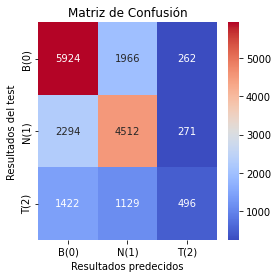

El accuracy global del modelo es 0.5981615233092581.


Estos son los scores para cada resultado


Resultado,0,1,2
sensibilidad,0.727,0.638,0.163
precisión,0.615,0.593,0.482
f1,0.666,0.615,0.243


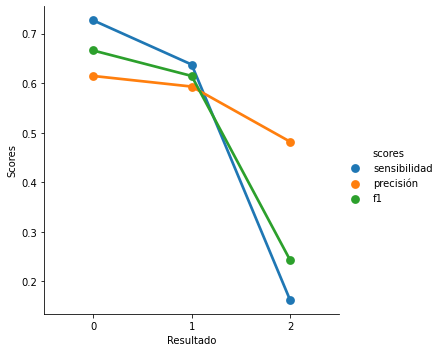



Estos son los errores de sensado (resultado mal identificado) y los errores de presición (resultado mal asignado):


Resultado,0,1,2,Total
Mal sensado,2228,2565,2551,7344
Mal predecido,3716,3095,533,7344




Aquí se muestra la frecuencia de cada uno de los 7344 errores cometidos:


frecuencia,2294,1966,1422,1129,271,262
y_test,1,0,2,2,1,0
y_pred,0,1,0,1,2,2




Estos son los errores de recall:


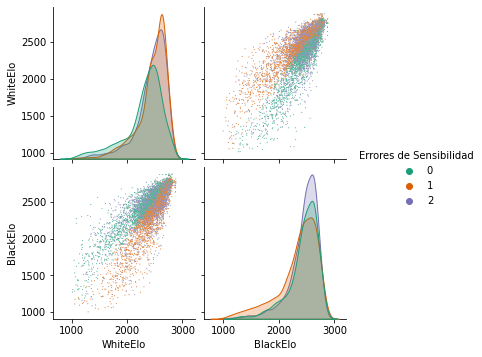



Estos son los errores de precisión:


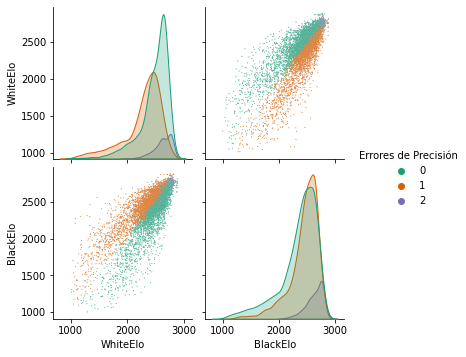



Aquí se grafican los seis tipos de errores posibles:


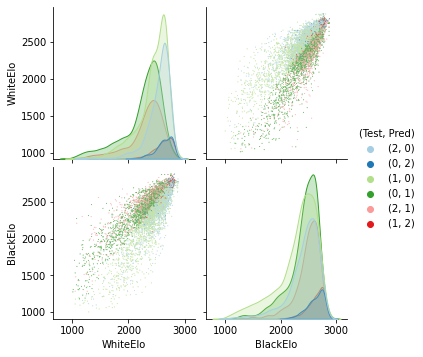

In [149]:
GRAFICAS(X_test_bz, y_test_bz, y_search_bz)